<a href="https://colab.research.google.com/github/amir9ume/practice_work/blob/master/recommendation_system_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'''
Code taken from this wonderful tutorial https://medium.com/towards-artificial-intelligence/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444

**Author(s): Saniya Parveez, Roberto Iriondo**
'''

# Netflix Recommendation System

URL: https://towardsai.net/recommendation-system-tutorial

**Data from Netflix**

*   combine_data_2.txt - This text file contains movie_id, customer_id, rating, date
*   List item - This CSV file contains movie_id and movie_title



In [ ]:
# Download datasets
!wget https://datasets.towardsai.net/combined_data_4.txt
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/new_features.csv

--2020-10-08 15:42:15--  http://datasets.towardsai.net/combined_data_4.txt
Resolving datasets.towardsai.net (datasets.towardsai.net)... 198.187.29.184
Connecting to datasets.towardsai.net (datasets.towardsai.net)|198.187.29.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552537802 (527M) [text/plain]
Saving to: ‘combined_data_4.txt’

combined_data_4.txt 100%[===================>] 526.94M  18.4MB/s    in 35s     

2020-10-08 15:42:50 (15.2 MB/s) - ‘combined_data_4.txt’ saved [552537802/552537802]

--2020-10-08 15:42:50--  https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577547 (564K) [text/plain]
Saving to: ‘movie_titles.csv.28’


In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 7.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670912 sha256=871e49f305bc110b12aaea3a98e069d8443198405528946490bc9b708d465ea9
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


Mount the data into google drive for files' persistence

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import Important Packages**

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# Load Data

*   combine_data_4.txt :- Read from this file. This is a comma separated file. It includes movie_id, customer_id, rating and date
*   netflix_rating.csv :- This is a csv file generated by reading from the combine_data_4.txt file





In [ ]:
def load_data():
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    rating_files = ['combined_data_4.txt'] 
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))  
                    netflix_csv_file.write('\n')
                    
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

**Display Netflix Rating Data**

In [ ]:
netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()

movie_id  customer_id  rating        date
0     13368      2385003       4  2004-07-08
1     13368       659432       3  2005-03-16
2     13368       751812       2  2002-12-16
3     13368      2625420       2  2004-05-25
4     13368      1650301       1  2005-08-30

**Check for the duplicate records**

In [ ]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

# Split Data into Train and Test Data

*   train_data = 80%
*   test_data = 20%


In [ ]:
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

#Analysis of Data

Count of Ratings - 1, 2, 3, 4, 5

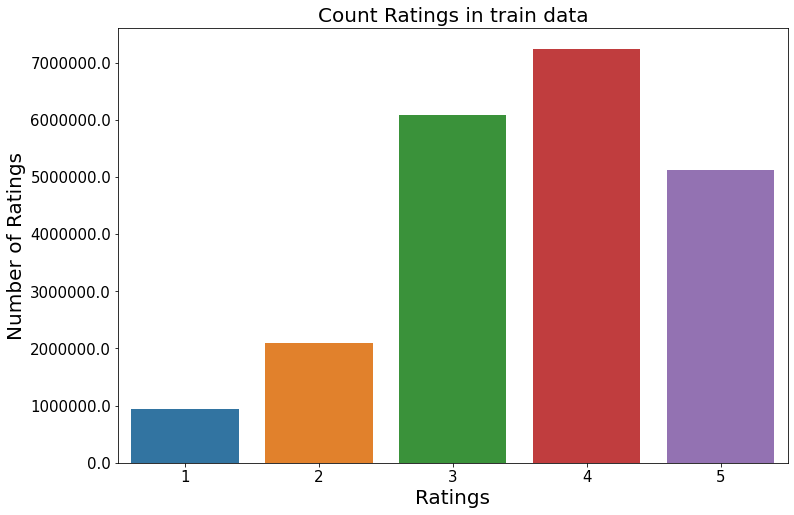

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

# Create User-Item Sparse Matrix

In User-Item sparse matrix, items' values are present in the column and users' values are present in the rows. The rating of the user is present in the cell.

In [ ]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

**Create Sparse Matrix from the Training Dataset**

In [ ]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

**Create Sparse Matrix from the Test Dataset**

In [ ]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

**Find Average Gloabal Rating of Movie**

In [ ]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.6291294662291467


**A Generic Method to Calculate Average Rating from Sparse Matrix**

In [ ]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

**Calculate Average User Rating**

In [ ]:
average_rating_user = get_average_rating(train_sparse_data, True)

**Calcualte Average Movie Rating**

In [ ]:
avg_rating_movie = get_average_rating(train_sparse_data, False)

# Check Cold Start Problem for Users

Here, 1% of total users are new and they will have no proper rating available. So, this can bring the issue of the cold start problems.

In [ ]:
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 475601
No. of Users in train data= 473014
No. of Users not present in train data = 2587(1.0%)


# Check Cold Start Problem for the Movies

Here, 20% of total movies are new and their rating might not be available in the dataset. So, this can bring the issue of the cold start problems.

In [ ]:
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 4403
No. of Movies in train data= 3515
No. of Movies not present in train data = 888(20.0%)


# Computation of user similarity to find similarities of top 100 users

In [ ]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [ ]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [ ]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Load Movie Titles

In [ ]:
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",",
                              header = None, names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head()

year_of_release                   movie_title
movie_id                                               
1                  2003.0               Dinosaur Planet
2                  2004.0    Isle of Man TT 2004 Review
3                  1997.0                     Character
4                  1994.0  Paula Abdul's Get Up & Dance
5                  2004.0      The Rise and Fall of ECW

# Compute Movie Similarity Matrix

In [ ]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [ ]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dario Argento Collection: Vol. 1: Phenomena', 0)


# Create Sample Sparse Matrix

This method will be used to generate Sample Sparse Matrix. New similarity features will be generated from this sample sparse matrix.

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

**Sample Sparse Matrix for the Traning Data**

In [ ]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

**Sample Sparse Matrix for the Test Data**

In [ ]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

# A Generic Method to Generate Similar Featuires.

This will generate below similar features:

*   similar_user_rating1
*   similar_user_rating2
*   similar_user_rating3
*   similar_user_rating4
*   similar_user_rating5
*   similar_movie_rating1
*   similar_movie_rating2
*   similar_movie_rating3
*   similar_movie_rating4
*   similar_movie_rating5











In [ ]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df
            

**Generate Similar Features for the Training Data**

In [ ]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [ ]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

user_id  movie_id  gloabl_average  ...  user_average  movie_average  rating
0   368756     13393        3.392157  ...           0.0            0.0     0.0
1  2593137     13495        3.392157  ...           0.0            0.0     0.0
2    96842     13602        3.392157  ...           5.0            0.0     0.0
3   486048     13602        3.392157  ...           3.0            0.0     0.0
4   940434     13602        3.392157  ...           5.0            0.0     0.0

[5 rows x 16 columns]

**Generate Similar Features for the Test Data**

In [ ]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [ ]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

user_id  movie_id  gloabl_average  ...  user_average  movie_average  rating
0   218348     16977        3.393939  ...      5.000000       3.583333     5.0
1   482111     16977        3.393939  ...      3.000000       3.583333     3.0
2   770495     16977        3.393939  ...      4.000000       3.583333     4.0
3  1033930     16977        3.393939  ...      2.666667       3.583333     3.0
4  1301848     16977        3.393939  ...      4.000000       3.583333     4.0

[5 rows x 16 columns]

# Building Machine Learning Model

In [ ]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [ ]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [ ]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[15:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=10, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

In [ ]:
y_pred_test = clf.predict(x_test)

In [ ]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.40467585617965873


# Plot Feature Importance

Feature importance is an important technique that selects a score to input features based on how valuable they are at predicting a target variable.

In [ ]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

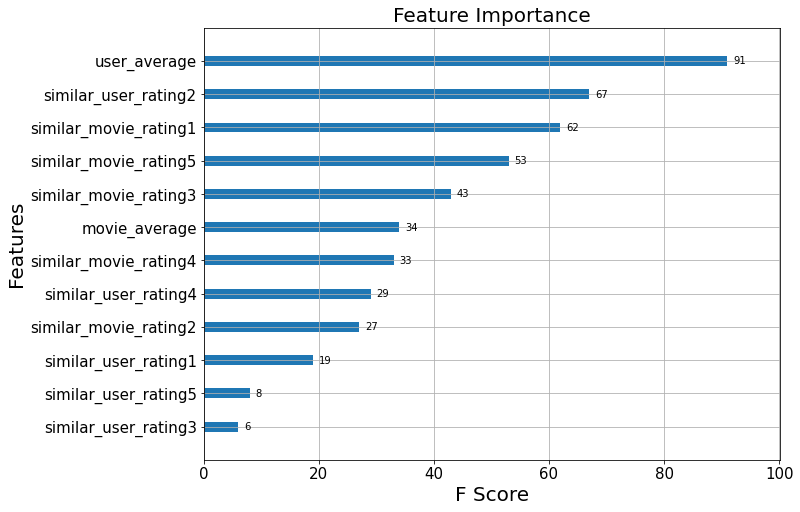

In [ ]:
 plot_importance(xgb, clf)